In [1]:
# Dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
from utils.policies import load_policy
from utils.config import load_config_nb
# Load config files
from utils.eval import EvaluatePolicy
from utils.sb3.reg_ppo import RegularizedPPO
import glob
import os

sns.set("notebook", font_scale=1.12, rc={"figure.figsize": (10, 5)})
sns.set_style("ticks", rc={"figure.facecolor": "none", "axes.facecolor": "none"})
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")
plt.set_loglevel("WARNING")
mpl.rcParams["lines.markersize"] = 8

In [2]:
# Load wandb figures
df_entropy = pd.read_csv("../evaluation/training_curves/pi_entropy.csv")
df_hr_ppo_ent = df_entropy.dropna(inplace=False, subset='HR-PPO - regularize/pi_entropy')
df_ppo_ent = df_entropy.dropna(inplace=False, subset='PPO - regularize/pi_entropy')
df_hr_ppo_ent['MA'] = df_hr_ppo_ent['HR-PPO - regularize/pi_entropy'].rolling(window=20).mean()
df_ppo_ent['MA'] = df_ppo_ent['PPO - regularize/pi_entropy'].rolling(window=20).mean()

df_kl = pd.read_csv("../evaluation/training_curves/kl_div.csv")
df_hr_ppo_kl = df_kl.dropna(inplace=False, subset='HR-PPO - regularize/kl_div')
df_ppo_kl = df_kl.dropna(inplace=False, subset='PPO - regularize/kl_div')
df_ppo_kl['MA'] = df_ppo_kl['PPO - regularize/kl_div'].rolling(window=20).mean()
df_hr_ppo_kl['MA'] = df_hr_ppo_kl['HR-PPO - regularize/kl_div'].rolling(window=20).mean()

df_loss_il = pd.read_csv("../evaluation/training_curves/loss_il_weighted.csv")
df_loss_il_ppo = df_loss_il.dropna(inplace=False, subset='PPO - regularize/loss_kl_weighted')
df_loss_il_hr_ppo = df_loss_il.dropna(inplace=False, subset='HR-PPO - regularize/loss_kl_weighted')
df_loss_il_hr_ppo['MA'] = df_loss_il_hr_ppo['HR-PPO - regularize/loss_kl_weighted'].rolling(window=25).mean()

df_loss_ppo = pd.read_csv("../evaluation/training_curves/loss_ppo_weighted.csv")
df_loss_ppo_ppo = df_loss_ppo.dropna(inplace=False, subset='PPO - regularize/loss_ppo_weighted')
df_loss_ppo_hr_ppo = df_loss_ppo.dropna(inplace=False, subset='HR-PPO - regularize/loss_ppo_weighted')
df_loss_ppo_ppo['MA'] = df_loss_ppo_ppo['PPO - regularize/loss_ppo_weighted'].rolling(window=25).mean()
df_loss_ppo_hr_ppo['MA'] = df_loss_ppo_hr_ppo['HR-PPO - regularize/loss_ppo_weighted'].rolling(window=25).mean()

df_reward = pd.read_csv("../evaluation/training_curves/reward.csv")
df_reward_ppo = df_reward.dropna(inplace=False, subset='PPO - rollout/ep_rew_mean_norm')
df_reward_hr_ppo = df_reward.dropna(inplace=False, subset='HR-PPO - rollout/ep_rew_mean_norm')
df_reward_ppo['MA'] = df_reward_ppo['PPO - rollout/ep_rew_mean_norm'].rolling(window=5).mean()
df_reward_hr_ppo['MA'] = df_reward_hr_ppo['HR-PPO - rollout/ep_rew_mean_norm'].rolling(window=5).mean()


df_tau_ent = pd.read_csv("../evaluation/training_curves/tau_entropy.csv")
df_tau_ppo_ent = df_tau_ent.dropna(inplace=False, subset='PPO - regularize/tau_entropy')
df_tau_hr_ppo_ent = df_tau_ent.dropna(inplace=False, subset='HR-PPO - regularize/tau_entropy')
df_tau_ppo_ent['MA'] = df_tau_ppo_ent['PPO - regularize/tau_entropy'].rolling(window=25).mean()
df_tau_hr_ppo_ent['MA'] = df_tau_hr_ppo_ent['HR-PPO - regularize/tau_entropy'].rolling(window=25).mean()

In [3]:
df_tau_ent

,global_step,HR-PPO - _step,HR-PPO - _step__MIN,HR-PPO - _step__MAX,HR-PPO - regularize/tau_entropy,HR-PPO - regularize/tau_entropy__MIN,HR-PPO - regularize/tau_entropy__MAX,PPO - _step,PPO - _step__MIN,PPO - _step__MAX,PPO - regularize/tau_entropy,PPO - regularize/tau_entropy__MIN,PPO - regularize/tau_entropy__MAX
0,30156,4.0,4.0,4.0,0.668329,0.668329,0.668329,NaN,NaN,NaN,NaN,NaN,NaN
1,30774,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,4.0,0.668329,0.668329,0.668329
2,49689,NaN,NaN,NaN,NaN,NaN,NaN,6.0,6.0,6.0,0.756949,0.756949,0.756949
3,51709,6.0,6.0,6.0,0.667255,0.667255,0.667255,NaN,NaN,NaN,NaN,NaN,NaN
4,67942,NaN,NaN,NaN,NaN,NaN,NaN,8.0,8.0,8.0,0.763185,0.763185,0.763185
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2487,32690287,NaN,NaN,NaN,NaN,NaN,NaN,2478.0,2478.0,2478.0,0.955772,0.955772,0.955772
2488,32711610,NaN,NaN,NaN,NaN,NaN,NaN,2480.0,2480.0,2480.0,0.947379,0.947379,0.947379
2489,32735037,NaN,NaN,NaN,NaN,NaN,NaN,2482.0,2482.0,2482.0,1.039093,1.039093,1.039093
2490,32766071,NaN,NaN,NaN,NaN,NaN,NaN,2484.0,2484.0,2484.0,0.963023,0.963023,0.963023


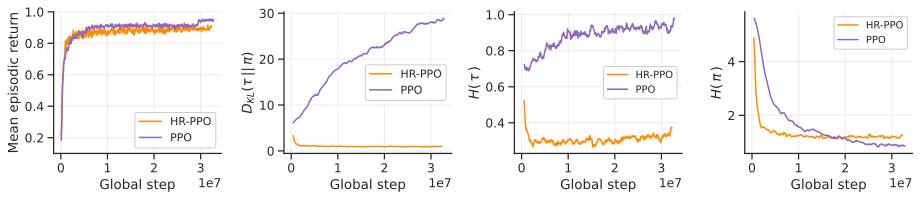

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(13, 3), sharex=True)

# Rew 
sns.lineplot(data=df_reward_hr_ppo, x='global_step', y='MA', color='darkorange', label='HR-PPO', ax=axs[0])
sns.lineplot(data=df_reward_ppo, x='global_step', y='MA', color='tab:purple', label='PPO', ax=axs[0])

# KL divergence
sns.lineplot(data=df_hr_ppo_kl, x='global_step', y='MA', color='darkorange', label='HR-PPO', ax=axs[1])
sns.lineplot(data=df_ppo_kl, x='global_step', y='MA', color='tab:purple', label='PPO', ax=axs[1])

# tau entropy
# sns.lineplot(data=df_loss_il_ppo, x='global_step', y='PPO - regularize/loss_kl_weighted', linestyle='--', color='grey', label=r'PPO: $\lambda \cdot D_{KL}$', ax=axs[2])
# sns.lineplot(data=df_loss_ppo_ppo, x='global_step', y='MA', color='b',  label=r'PPO: $\lambda \cdot L^{PPO}$', ax=axs[2])

sns.lineplot(data=df_tau_hr_ppo_ent, x='global_step', y='MA', color='darkorange', label=r'HR-PPO', ax=axs[2])
sns.lineplot(data=df_tau_ppo_ent, x='global_step', y='MA', color='tab:purple', label=r'PPO', ax=axs[2])

# Entropy rl policy
sns.lineplot(data=df_hr_ppo_ent, x='global_step', y='MA', color='darkorange', label=r'HR-PPO', ax=axs[3])
sns.lineplot(data=df_ppo_ent, x='global_step', y='MA', color='tab:purple', label='PPO', ax=axs[3])

axs[0].set_xlabel('Global step')
axs[1].set_xlabel('Global step')
axs[2].set_xlabel('Global step')
axs[3].set_xlabel('Global step')

axs[0].grid(True, alpha=0.35)
axs[0].set_ylim([0.1, 1])
axs[1].grid(True, alpha=0.35)
axs[2].grid(True, alpha=0.35)
axs[3].grid(True, alpha=0.35)
axs[0].legend(facecolor='white', framealpha=1, fontsize=11)
axs[1].legend(facecolor='white', framealpha=1, fontsize=11)
axs[2].legend(facecolor='white', framealpha=1, fontsize=10)
axs[3].legend(facecolor='white', framealpha=1, fontsize=10)

axs[0].set_ylabel('Mean episodic return')
axs[1].set_ylabel(r'$D_{KL}(\tau \, || \, \pi)$')
axs[2].set_ylabel(r'$H(\, \tau \, )$')
axs[3].set_ylabel(r'$H(\, \pi \, )$')

plt.tight_layout()
sns.despine()

plt.savefig(f'training_examples.pdf', bbox_inches="tight")